In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd '/content/drive/My Drive/Colab Notebooks/Cross Modal Retrieval'

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive
/content/drive/My Drive/Colab Notebooks/Cross Modal Retrieval


In [ ]:
!pip install open3d
!pip install torch-geometric \
  torch-sparse==latest+cu101 \
  torch-scatter==latest+cu101 \
  torch-cluster==latest+cu101 \
  -f https://pytorch-geometric.com/whl/torch-1.5.0.html

     |████████████████████████████████| 4.6MB 5.3MB/s 
Looking in links: https://pytorch-geometric.com/whl/torch-1.5.0.html
     |████████████████████████████████| 174kB 4.6MB/s 
     |████████████████████████████████| 21.6MB 1.2MB/s 
     |████████████████████████████████| 12.3MB 1.1MB/s 
     |████████████████████████████████| 22.0MB 1.2MB/s 
     |████████████████████████████████| 235kB 13.5MB/s 
     |████████████████████████████████| 2.1MB 12.2MB/s 
     |████████████████████████████████| 51kB 5.3MB/s 
  Created wheel for torch-geometric: filename=torch_geometric-1.6.0-cp36-none-any.whl size=296339 sha256=4686d485d9d704b5cfe94d556b796cbb459bced887a86a475586839fb6d7f9ec
  Stored in directory: /root/.cache/pip/wheels/5f/7f/33/acea5809d8580a7adf60dcd6d04f5fc50a7f983040f68be1ff
Successfully built torch-geometric


In [ ]:
from text_extraction_torch import get_text_embedding
import open3d as o3d
import os
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

embedding_matrix, encoder_input_sentences,modelIdList,categoryList,caption_length = get_text_embedding("descriptions.csv")
print("embedding_matrix:",embedding_matrix.shape,"sentences:",encoder_input_sentences.shape,"modelIdList:",len(modelIdList))

Chair/2b110b833111b38c420adf24e49f74c8.ply does not exist
Chair/bd6bc40b3327e5109501f2fa226917d0.ply does not exist
Chair/1d498876c8890f7786470a1318504fef.ply does not exist
Chair/8979c1aaa6675009bf80985a99195eb8.ply does not exist
Chair/e4b40369894a16ce6821a1e68ba5ebab.ply does not exist
Chair/311c07b96ce39f82c70d3fe6f2ca143f.ply does not exist
Chair/bdd57499bf64fab6bf80985a99195eb8.ply does not exist
Chair/5ce323f8499cf60ce51e3cd2b72fbf02.ply does not exist
Chair/9ee4b9c97bcf4b3715dec43ae6a12831.ply does not exist
Chair/c9288e09458ec0e9bbc45ba666751519.ply does not exist
Chair/48429b3467c7185060fcaed6cc231482.ply does not exist
Chair/5afc95ed2a26ce548644074928ab3f32.ply does not exist
Chair/475cf49d3764f04ecc8bd7a04c9659f1.ply does not exist
Chair/e4b40369894a16ce6821a1e68ba5ebab.ply does not exist
Chair/bdd57499bf64fab6bf80985a99195eb8.ply does not exist
Table/10cd74fb0af8021fbf7cf6012a0af9fc.ply does not exist
Chair/e6a5c9fdb609d00a5ff6fe84f53e00a5.ply does not exist
Chair/64198879

In [ ]:
#print(encoder_input_sentences[0])
#print(embedding_matrix[0])
#print(embedding_matrix[2])

In [ ]:
class ShapeText(Dataset):
    def __init__(self, encoder_input_sentences,modelIdList, categoryList, train=True, transform=None):
        self.is_train = train
        self.transform = transform
        self.encoder_input_sentences = encoder_input_sentences
        self.files = []
        for idx,modelId in enumerate(modelIdList):
            sample = os.path.join(categoryList[idx], modelId + ".ply")
            self.files.append(sample)
          
    
    def __len__(self):
        return len(self.files)
    
    def __preproc__(self, pcd_load):
        # convert Open3D.o3d.geometry.PointCloud to numpy array
        xyz_load = np.asarray(pcd_load.points)
        color_load = np.asarray(pcd_load.colors)
        if self.transform:
            xyz = self.transform(xyz_load)
        return xyz,color_load

    def __getitem__(self, idx):
        pcd_path = self.files[idx]
        pcd_load = o3d.io.read_point_cloud(pcd_path)
        pos_xyz, pos_color = self.__preproc__(pcd_load)
        pos_desc = self.encoder_input_sentences[idx]
        if not self.is_train:
          return self.files[idx], {'xyz': pos_xyz, 'color': pos_color}, pos_desc
        negative_idx = random.choice([ i for i in range(len(self.files)) if (i != idx and modelIdList[i]!=modelIdList[idx])])
        neg_text = self.encoder_input_sentences[negative_idx]
        pcd_path = self.files[negative_idx]
        pcd_load = o3d.io.read_point_cloud(pcd_path)
        neg_xyz, neg_color = self.__preproc__(pcd_load)
        return self.files[idx],{'xyz': pos_xyz, 'color': pos_color},pos_desc, neg_text,{'xyz': neg_xyz, 'color': neg_color}

In [ ]:
from torch import nn
class TripletLoss(nn.Module):
    def __init__(self, margin= 0.70):
        super(TripletLoss, self).__init__()
        self.margin = margin
        
    def calc_euclidean(self, x1, x2):
       # x1_norm = x1.norm(p=2,dim=1)
      #  x2_norm = x2.norm(p=2,dim=1)
        return (x1 - x2).pow(2).sum(1)
    
    def forward(self, positive_shape: torch.Tensor, positive_text: torch.Tensor, negative_text: torch.Tensor, negative_shape: torch.Tensor) -> torch.Tensor:
        distance_positive = self.calc_euclidean(positive_shape, positive_text)
        distance_negative = self.calc_euclidean(positive_shape, negative_text)
        losses = torch.relu(distance_positive - distance_negative + self.margin)
        distance_negative = self.calc_euclidean(negative_shape, positive_text)
        losses += torch.relu(distance_positive - distance_negative + self.margin)
        return losses.mean()


class MSELoss(nn.Module):
    def __init__(self):
        super(MSELoss, self).__init__()
        
    def calc_euclidean(self, x1, x2):
       # x1_norm = x1.norm(p=2,dim=1)
      #  x2_norm = x2.norm(p=2,dim=1)
        return (x1 - x2).pow(2).sum(1)
    
    def forward(self, positive_shape: torch.Tensor, positive_text: torch.Tensor) -> torch.Tensor:
        distance_positive = self.calc_euclidean(positive_shape, positive_text)
        return distance_positive.mean()

In [ ]:
import open3d as o3d
import os
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

class Normalize(object):
    def __call__(self, pointcloud):
        assert len(pointcloud.shape)==2
        
        norm_pointcloud = pointcloud - np.mean(pointcloud, axis=0)
        norm_pointcloud /= np.max(np.linalg.norm(norm_pointcloud, axis=1))

        return  norm_pointcloud

class RandRotation_z(object):
    def __call__(self, pointcloud):
        assert len(pointcloud.shape)==2

        theta = random.random() * 2. * math.pi
        rot_matrix = np.array([[ math.cos(theta), -math.sin(theta),    0],
                               [ math.sin(theta),  math.cos(theta),    0],
                               [0,                             0,      1]])
        
        rot_pointcloud = rot_matrix.dot(pointcloud.T).T
        return  rot_pointcloud
    
class RandomNoise(object):
    def __call__(self, pointcloud):
        assert len(pointcloud.shape)==2

        noise = np.random.normal(0, 0.02, (pointcloud.shape))
    
        noisy_pointcloud = pointcloud + noise
        return  noisy_pointcloud
        
class ToTensor(object):
    def __call__(self, pointcloud):
        assert len(pointcloud.shape)==2
        return torch.from_numpy(pointcloud)
    
def default_transforms():
    return transforms.Compose([ Normalize(),
                                ToTensor()
                              ])

In [ ]:
def calculateNearest(firstEmbed,secEmbed):
  correctIndex = []
  predictedIndex = []
  difference = []
  firstEmbed_norm = firstEmbed.norm(p=2,dim=1)
  secEmbed_norm = secEmbed.norm(p=2,dim=1)
  for i in range(len(firstEmbed)):
      distance = (secEmbed-firstEmbed[i]).pow(2).sum(1)
      idx, val= torch.argmin(distance).item(),torch.min(distance).item()
      correctIndex.append(i)
      predictedIndex.append(idx)
      difference.append(val)
  print("correctIndex:", correctIndex)
  print("predictedIndex:", predictedIndex)
  print("difference:", difference)
  return correctIndex,predictedIndex,difference

def calculateAllNearest(firstEmbed, secEmbed, path):
  rr_1 = []
  rr_5 = []
  rr_10 = []
  firstEmbed_norm = firstEmbed.norm(p=2,dim=1)
  secEmbed_norm = secEmbed.norm(p=2,dim=1)
  for i in range(len(firstEmbed)):
      distance = (secEmbed-firstEmbed[i]).pow(2).sum(1)
      val_10, idx_10 = torch.topk(distance, 10, largest = False)
      rr_1.append(path[i]) if idx_10[0] == i else rr_1.append("")
      rr_5.append(path[i]) if i in idx_10[:5] else rr_5.append("")
      rr_10.append(path[i]) if i in idx_10 else rr_10.append("")
  print("func:",len(rr_1),len(rr_5),len(rr_10))
  return rr_1,rr_5,rr_10

In [ ]:

def NN_loss(x, y, dim=1):
    dist = batch_pairwise_dist(x,y)
    values, indices = dist.min(dim=dim)
    return values.mean(dim=-1)


def batch_pairwise_dist(a,b):
    x,y = a,b
    bs, num_points, points_dim = x.size()
    xx = torch.bmm(x, x.transpose(2,1))
    yy = torch.bmm(y, y.transpose(2,1))
    zz = torch.bmm(x, y.transpose(2,1))
    diag_ind = torch.arange(0, num_points).type(torch.cuda.LongTensor)
    rx = xx[:, diag_ind, diag_ind].unsqueeze(1).expand_as(xx)
    ry = yy[:, diag_ind, diag_ind].unsqueeze(1).expand_as(yy)
    P = (rx.transpose(2,1) + ry - 2*zz)
    return P

In [ ]:
def batch_pairwise_dist(xyz1, xyz2):
    r_xyz1 = torch.sum(xyz1 * xyz1, dim=2, keepdim=True)  # (B,N,1)
    r_xyz2 = torch.sum(xyz2 * xyz2, dim=2, keepdim=True)  # (B,M,1)
    mul = torch.matmul(xyz2, xyz1.permute(0,2,1))         # (B,M,N)
    dist = r_xyz2 - 2 * mul + r_xyz1.permute(0,2,1)       # (B,M,N)
    return dist

def batch_NN_loss(x, y):
    dist = batch_pairwise_dist(x,y)
    #print("dist:",dist.shape)
    values1, indices = dist.min(dim=1)
   # print(values1.shape)
    loss1 = values1.mean(dim=-1)
   # print("loss1", loss1.shape)
    values2, indices = dist.min(dim=2)
   # print(values2.shape)
    loss2 = values2.mean(dim=-1)
    #print("loss2",loss2.shape)
    loss = torch.max(loss1,loss2).mean()
    return loss

In [ ]:
def evaluate(model, trg_vocab_size, trg_len, input, shape_out, teacher_forcing_ratio=1):
  #model.eval()
  #print(trg_vocab_size, trg_len, input.shape, shape_out.shape)
  device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
  with torch.no_grad():
    outputs = torch.zeros(len(input), trg_len, trg_vocab_size).to(device)
    hidden = shape_out.unsqueeze(0)
    cell = hidden
    for t in range(trg_len):
      output, hidden, cell = model(input, hidden, cell)
      #place predictions in a tensor holding predictions for each token
      outputs[:,t:t+1,:] = output
      #get the highest predicted token from our predictions
      input = output.argmax(2)
    return outputs

In [ ]:
from PointNet2 import PointNet2ClsMsg
from embeddings import Encoder
from embedding import ShapeDecoder
from TextDecoder import Decoder
import random

train_split =  int(0.9 * len(modelIdList))
val_split = int(0.95 * len(modelIdList))
train_ds = ShapeText(encoder_input_sentences[ :train_split,:], modelIdList[ :train_split], categoryList[ :train_split], transform=default_transforms())

val_ds = ShapeText(encoder_input_sentences[train_split:val_split,:], modelIdList[train_split:val_split],
                     categoryList[train_split:val_split], train = False, transform=default_transforms())
test_ds = ShapeText(encoder_input_sentences[val_split: ,:], modelIdList[val_split: ], categoryList[val_split: ],
                    train = False, transform=default_transforms())
train_loader = DataLoader(dataset=train_ds, batch_size=16, shuffle=True)
val_loader = DataLoader(dataset=val_ds, batch_size=32, shuffle=False)
test_loader = DataLoader(dataset=test_ds, batch_size=32, shuffle=False)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
HIDDEN_SIZE = 300
criterion = TripletLoss()
shape_model = PointNet2ClsMsg().to(device)
text_model = Encoder(embedding_matrix, HIDDEN_SIZE, n_layers=2).to(device)
shape_decoder = ShapeDecoder(300).to(device)
text_decoder = Decoder(embedding_matrix.astype(np.float32), embedding_matrix.shape[0], 300).to(device)
shape_model.load_state_dict(torch.load("shape_model_triplet_l21.checkpoint"))
text_model.load_state_dict(torch.load("text_model_triplet_l21.checkpoint"))
#text_decoder.load_state_dict(torch.load("text_decoder1.checkpoint"))
#shape_decoder.load_state_dict(torch.load("shape_decoder1.checkpoint"))
params = list(shape_model.parameters()) + list(text_model.parameters()) + list(shape_decoder.parameters()) + list(text_decoder.parameters()) 
optimizer = torch.optim.Adam(params, lr=5e-5)
shape_model.train()
text_model.train()
shape_decoder.train()
text_decoder.train()
train_loss_history = []
train_acc_shape_history = []
train_acc_text_history = []
val_acc_shape_history = []
val_acc_text_history = []
val_loss_history = []
num_epochs = 5
iter_per_epoch = len(train_loader)
log_nth = 10
for epoch in range(num_epochs):
    running_loss = []
    total = 0
    corrText = 0
    corrShape = 0
    for i, (path,anchor_shape, pos_text, neg_text,neg_shape) in enumerate(train_loader):
        pos_text = pos_text.to(device)
        neg_text = neg_text.to(device)
        optimizer.zero_grad()
        a_shape = {}
        a_shape["xyz"], a_shape["color"] = anchor_shape["xyz"].permute(0,2,1).float(), anchor_shape["color"].permute(0,2,1).float()
        neg_shape["xyz"], neg_shape["color"] = neg_shape["xyz"].permute(0,2,1).float(), neg_shape["color"].permute(0,2,1).float()
        anchor_out = shape_model(a_shape)
        neg_shape_out = shape_model(neg_shape)
        positive_out = text_model(pos_text)
        negative_out = text_model(neg_text)

        xyz,color = anchor_shape["xyz"].float().to(device), anchor_shape["color"].float().to(device)
        rec_xyz = shape_decoder(positive_out)
        point_cloud = torch.cat((xyz,color),dim=2)
        shape_rec_loss = batch_NN_loss(point_cloud,rec_xyz)
        
        text_out , _ , _ = text_decoder(pos_text[:,:-1], anchor_out.unsqueeze(0), anchor_out.unsqueeze(0))
        criterion2 = nn.CrossEntropyLoss(ignore_index = 0)
        #l2_loss = criterion3(positive_out,anchor_out)
        text_rec_loss = criterion2(text_out.reshape(-1,embedding_matrix.shape[0]), pos_text[:, 1:].reshape(-1))
        
        loss = criterion(anchor_out, positive_out, negative_out, neg_shape_out) + shape_rec_loss + text_rec_loss 
        loss.backward()
        optimizer.step()
        
        
        if (i+1) % log_nth == 0:
            
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                    .format(epoch+1, num_epochs, i+1, iter_per_epoch, loss.item()))
            
        if  (i+1)%500 == 0 : 
            print("pos_out:",positive_out[0,:10],"neg_out:",negative_out[0,:10],"anchor_out:",anchor_out[0,:10])
            correctText,predictedText,difference = calculateNearest(anchor_out, positive_out)
            correctShape,predictedShape,difference = calculateNearest(positive_out, anchor_out)
            total = len(correctShape)
            corrText = np.sum(np.array(correctText) == np.array(predictedText))
            corrShape = np.sum(np.array(correctShape) == np.array(predictedShape))
            shapeAcc = 100 * (corrShape / total)
            textAcc = 100 * (corrText / total)
            print('Train: Text to Shape Retrieval accuracy: {} %'.format(shapeAcc) )
            print('Train: Shape to Text Retrieval accuracy: {} %'.format(textAcc) )
            train_acc_shape_history.append(shapeAcc)
            train_acc_text_history.append(textAcc)
      # Validate the model
        if  (i+1)%iter_per_epoch == 0:
          torch.save(shape_model.state_dict(), "shape_model_l2.checkpoint")
          torch.save(text_model.state_dict(), "text_model_l2.checkpoint")
          torch.save(text_decoder.state_dict(), "text_decoder_l2.checkpoint")
          torch.save(shape_decoder.state_dict(), "shape_decoder_l2.checkpoint")
          with torch.no_grad():
            corrText = 0
            corrShape = 0
            total = 0
            for (path,shape, text) in val_loader:
                text = text.to(device)
                shape["xyz"],shape["color"] = shape["xyz"].permute(0,2,1).float(), shape["color"].permute(0,2,1).float()
                text_embed = text_model(text)
                shape_embed = shape_model(shape)
                correctText,predictedText,difference = calculateNearest(shape_embed, text_embed)
                correctShape,predictedShape,difference = calculateNearest(text_embed, shape_embed)
                total += len(correctShape)
                corrText += np.sum(np.array(correctText) == np.array(predictedText))
                corrShape += np.sum(np.array(correctShape) == np.array(predictedShape))

            shapeAcc = 100 * (corrShape / total)
            textAcc = 100 * (corrText / total)
            print('Validate: Text to Shape Retrieval accuracy: {} %'.format(shapeAcc) )
            print('Validate: Shape to Text Retrieval accuracy: {} %'.format(textAcc) )
            val_acc_shape_history.append(shapeAcc)
            val_acc_text_history.append(textAcc)

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/rnn.py:50: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.25 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


Streaming output truncated to the last 5000 lines.
predictedIndex: [0, 4, 2, 6, 22, 5, 5, 5, 0, 11, 10, 31, 13, 4, 14, 4, 21, 17, 10, 14, 20, 21, 22, 17, 10, 25, 18, 4, 21, 0, 13, 25]
difference: [7.183198928833008, 6.335384368896484, 6.011382102966309, 7.418391704559326, 6.628226280212402, 5.5018415451049805, 6.072022914886475, 7.845327854156494, 7.338748455047607, 7.991731643676758, 6.39957332611084, 7.701704025268555, 7.561866283416748, 6.232597351074219, 7.842974662780762, 6.922107696533203, 6.670962333679199, 6.119704246520996, 6.578474044799805, 6.907790660858154, 6.7715864181518555, 5.749396800994873, 6.243114471435547, 6.763571739196777, 6.273366928100586, 7.354761123657227, 7.385296821594238, 6.87441349029541, 6.080114364624023, 7.61123514175415, 6.955208778381348, 7.527994155883789]
correctIndex: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31]
predictedIndex: [20, 9, 2, 3, 31, 20, 6, 4, 29, 9, 10, 11, 12, 

In [ ]:
def write_file(filepath,rr1_Text,rr5_Text,rr10_Text,rr1_Shape,rr5_Shape,rr10_Shape):
    print("file written")
    with open(filepath, 'w') as file:
      file.write("RR@1 Text Accuracy:\n")
      for s in rr1_Text:
        if s != "":
          file.write(s)
          file.write("\n")
      file.write("RR@5 Text Accuracy:\n")
      for s in rr5_Text:
        if s != "":
          file.write(s) 
          file.write("\n")
      file.write("RR@10 Text Accuracy:\n")
      for s in rr10_Text:
        if s != "":
          file.write(s)
          file.write("\n")
      file.write("RR@1 Shape Accuracy:\n")
      for s in rr1_Shape:
        if s != "":
          file.write(s)
          file.write("\n")
      file.write("RR@5 Shape Accuracy:\n")
      for s in rr5_Shape:
        if s != "":
          file.write(s)
          file.write("\n")
      file.write("RR@10 Shape Accuracy:\n")
      for s in rr10_Shape:
        if s != "":
          file.write(s) 
          file.write("\n")
      file.close()

In [ ]:
#from PointNet2 import Net
from PointNet2 import PointNet2ClsMsg
from embedding import Encoder
from embedding import ShapeDecoder
from TextDecoder import Decoder
import random
train_split =  int(0.9 * len(modelIdList))
val_split = int(0.95 * len(modelIdList))

#val_ds = ShapeText(encoder_input_sentences[train_split:val_split,:], modelIdList[train_split:val_split],
#                     categoryList[train_split:val_split], train = False, transform=default_transforms())
test_ds = ShapeText(encoder_input_sentences[val_split: ,:], modelIdList[val_split: ], categoryList[val_split: ],
                    train = False, transform=default_transforms())
#val_loader = DataLoader(dataset=val_ds, batch_size=32, shuffle=False)
test_loader = DataLoader(dataset=test_ds, batch_size=64, shuffle=False)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
HIDDEN_SIZE = 300
shape_model = PointNet2ClsMsg().to(device)
text_model = Encoder(embedding_matrix, HIDDEN_SIZE, n_layers=2).to(device)
shape_decoder = ShapeDecoder(300).to(device)
text_decoder = Decoder(embedding_matrix.astype(np.float32), embedding_matrix.shape[0], 300).to(device)
shape_model.load_state_dict(torch.load("shape_model_l2.checkpoint"))
text_model.load_state_dict(torch.load("text_model_l2.checkpoint"))
text_decoder.load_state_dict(torch.load("text_decoder.checkpoint"))
shape_decoder.load_state_dict(torch.load("shape_decoder.checkpoint"))
shape_embed_list = torch.zeros(0, 0).to(device)
text_embed_list = torch.zeros(0, 0).to(device)
path_list=[]
print(len(modelIdList))
shape_model.eval()
text_model.eval()
shape_decoder.eval()
text_decoder.eval()
with torch.no_grad():
    corrText = 0
    corrShape = 0
    total = 0
    for path,shape, text in test_loader:
      text = text.to(device)
      shape["xyz"],shape["color"] = shape["xyz"].permute(0,2,1).float(), shape["color"].permute(0,2,1).float()
      text_embed = text_model(text)
      shape_embed = shape_model(shape)
      text_embed_list = torch.cat((text_embed_list,text_embed),dim=0) if len(text_embed_list)!=0 else text_embed
      shape_embed_list = torch.cat((shape_embed_list,shape_embed),dim=0) if len(shape_embed_list)!=0 else shape_embed
      path_list.extend(list(path))
    print(len(path_list))
    rr1_Text,rr5_Text,rr10_Text = calculateAllNearest(shape_embed_list, text_embed_list, path_list)
    rr1_Shape,rr5_Shape,rr10_Shape = calculateAllNearest(text_embed_list, shape_embed_list, path_list)
    rr1TextAcc,rr5TextAcc, rr10TextAcc = np.sum(np.array(rr1_Text)!=""),np.sum(np.array(rr5_Text)!=""),np.sum(np.array(rr10_Text)!="")
    rr1ShapeAcc,rr5ShapeAcc, rr10ShapeAcc = np.sum(np.array(rr1_Shape)!=""),np.sum(np.array(rr5_Shape)!=""),np.sum(np.array(rr10_Shape)!="")
    total = 100/len(rr1_Shape)
    write_file("total_loss_results1",rr1_Text,rr5_Text,rr10_Text,rr1_Shape,rr5_Shape,rr10_Shape)
    print("rr1ShapeAcc:", rr1ShapeAcc*total, "rr5ShapeAcc:", rr5ShapeAcc*total, "rr10ShapeAcc:", rr10ShapeAcc*total)
    print("rr1TextAcc:", rr1TextAcc*total, "rr5TextAcc:", rr5TextAcc*total, "rr10TextAcc:", rr10TextAcc*total)
      

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/rnn.py:50: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.25 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


72759
3638
func: 3638 3638 3638
func: 3638 3638 3638
file written
rr1ShapeAcc: 0.02748763056624519 rr5ShapeAcc: 0.13743815283122596 rr10ShapeAcc: 0.2748763056624519
rr1TextAcc: 0.02748763056624519 rr5TextAcc: 0.10995052226498075 rr10TextAcc: 0.2748763056624519


['bba5ce8555c8fa89ba18ade30e563d37', '3b3a9f4e3aa9f2f4d39a194653571dfc', 'be509f0aab6ce96251d3c864cc68e22e', '5d93e285b2006520ab610b0c94236463', '6a20911ef197f358efa66822a012535e', 'cb242dc225308003de21d22522bdaf', '30b176f8b5e7e04ceed0bb714b97ca82', '7212f652dd37232a80360680c1602c7d', '64067f7029087ee07eaeab1f0c9120b7', '6c8d4952f67d47f56bf829b05be0ce22', 'b9e93c2036f24661ae890f02c6b951ff', '9bda786a525b1ef93a11565e5be9cf53', '7ae9c3f17c5f9c569284ac9fef3539eb', '336e92c7c570250251c4deb11af7079e', '611e834a83c63f50a8840b31c6de34ce']
Epoch [15/2500], Step [1/1], Loss: 0.4096
Epoch [30/2500], Step [1/1], Loss: 0.1457
Epoch [45/2500], Step [1/1], Loss: 0.1087
Epoch [60/2500], Step [1/1], Loss: 0.0802
Epoch [75/2500], Step [1/1], Loss: 0.0683
Epoch [90/2500], Step [1/1], Loss: 0.0770
Epoch [105/2500], Step [1/1], Loss: 0.0664
Epoch [120/2500], Step [1/1], Loss: 0.0535
Epoch [135/2500], Step [1/1], Loss: 0.0465
Epoch [150/2500], Step [1/1], Loss: 0.0426
Epoch [165/2500], Step [1/1], Loss: 0

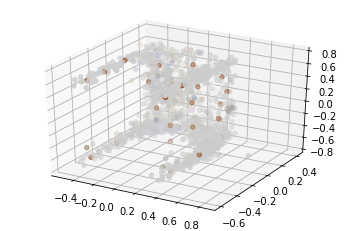

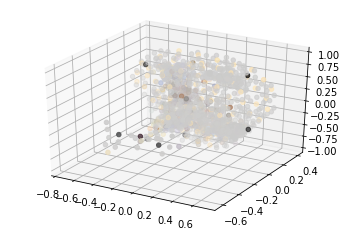

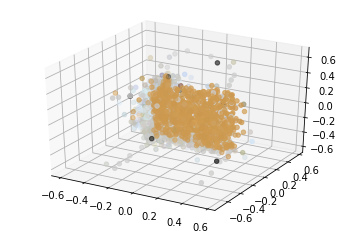

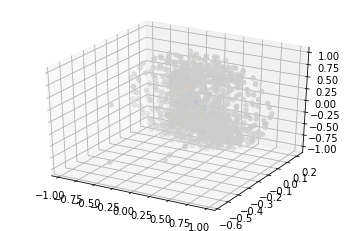

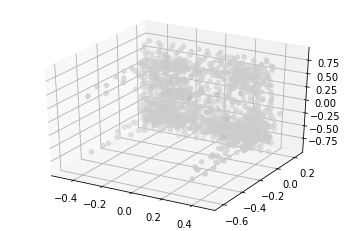

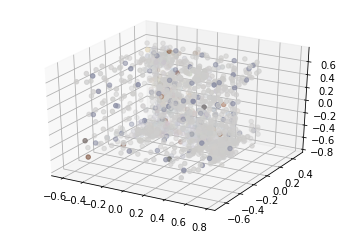

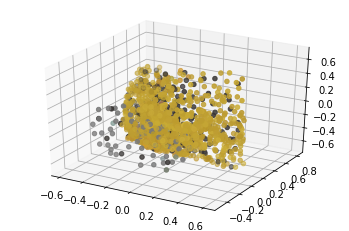

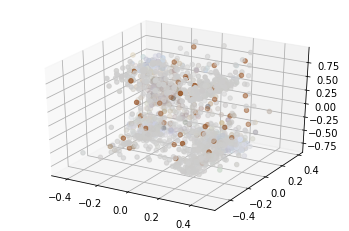

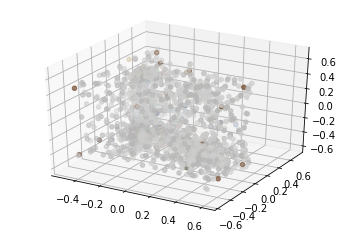

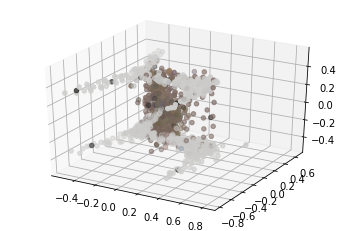

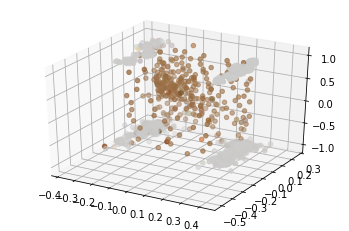

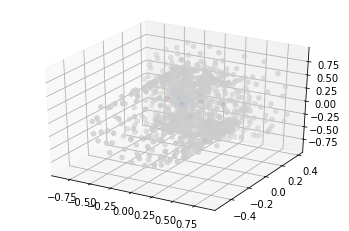

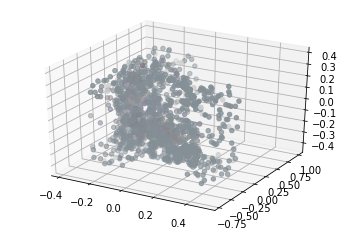

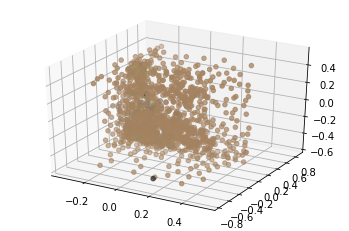

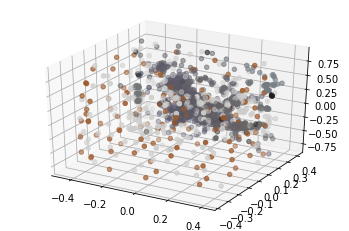

In [ ]:
from PointNet2 import Net
from embedding import Encoder
from embedding import ShapeDecoder
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import random

train_split =  int(0.8*len(modelIdList))
val_split = int(0.9 * len(modelIdList))
train_ds = ShapeText(encoder_input_sentences[ :train_split,:], modelIdList[ :train_split], categoryList[ :train_split], transform=default_transforms())
val_ds = ShapeText(encoder_input_sentences[train_split:val_split,:], modelIdList[train_split:val_split],
                     categoryList[train_split:val_split], train = False, transform=default_transforms())
test_ds = ShapeText(encoder_input_sentences[val_split: ,:], modelIdList[val_split: ], categoryList[val_split: ],
                    train = False, transform=default_transforms())
train_loader = DataLoader(dataset=train_ds, batch_size=15, shuffle=True)
val_loader = DataLoader(dataset=val_ds, batch_size=32, shuffle=False)
test_loader = DataLoader(dataset=test_ds, batch_size=32, shuffle=False)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
shape_decoder = ShapeDecoder(300).to(device)
HIDDEN_SIZE = 300
text_model = Encoder(embedding_matrix, HIDDEN_SIZE).to(device)
params = list(shape_decoder.parameters()) + list(text_model.parameters())
optimizer = torch.optim.Adam(params, lr=0.005)
text_model.train()
print(modelIdList)
shape_decoder.train()
num_epochs = 2500
iter_per_epoch = len(train_loader)
log_nth = 10
for epoch in range(num_epochs):
    running_loss = []
    total = 0
    corrText = 0
    corrShape = 0
    for i, (anchor_shape, pos_text, neg_text,neg_shape) in enumerate(train_loader):
        pos_text = pos_text.to(device)
        optimizer.zero_grad()
        xyz,color = anchor_shape["xyz"].float().to(device), anchor_shape["color"].float().to(device)
        positive_out = text_model(pos_text)
        rec_shape = shape_decoder(positive_out)
        point_cloud = torch.cat((xyz,color),dim=2)
        loss = batch_NN_loss(point_cloud,rec_shape)
        #print(" loss.data:",loss.data)
        loss.backward()
        #print("shape_model grad:",(shape_decoder.l2.weight.grad!=0.).sum())
        optimizer.step()
        if (epoch+1) % 15 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                    .format(epoch+1, num_epochs, i+1, iter_per_epoch, loss.item()))
      # Validate the model
    if (epoch+1)%num_epochs == 0:
      for ix in range(len(rec_shape)):
        plt.subplot(131)
        ax = plt.axes(projection='3d')
        color_map = torch.clamp(rec_shape[ix,:,3:],0,1)
        rec_shp = np.array(rec_shape.detach().to('cpu'))
        ax.scatter(rec_shp[ix,:,0],rec_shp[ix,:,1],rec_shp[ix,:,2],color=color_map.detach().to('cpu'))
        #plt.subplot(132)
        #xyz = xyz.to('cpu')
        #print(xyz.shape)
        #ax.scatter(xyz[ix,:,0],xyz[ix,:,1],xyz[ix,:,2])
        plt.show()


In [ ]:
def evaluate(model, trg_vocab_size, trg_len, input, shape_out, teacher_forcing_ratio=1):
  #model.eval()
  #print(trg_vocab_size, trg_len, input.shape, shape_out.shape)
  device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
  with torch.no_grad():
    outputs = torch.zeros(len(input), trg_len, trg_vocab_size).to(device)
    hidden = shape_out.unsqueeze(0)
    cell = hidden
    for t in range(trg_len):
      output, hidden, cell = model(input, hidden, cell)
      #place predictions in a tensor holding predictions for each token
      outputs[:,t:t+1,:] = output
      #get the highest predicted token from our predictions
      input = output.argmax(2)
    return outputs

In [ ]:
from TextDecoder import Decoder
from PointNet2 import Net
import random

train_split =  int(1*len(modelIdList))
val_split = int(0.9 * len(modelIdList))
train_ds = ShapeText(encoder_input_sentences[ :train_split,:], modelIdList[ :train_split], categoryList[ :train_split], transform=default_transforms())

train_loader = DataLoader(dataset=train_ds, batch_size=15, shuffle=True)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
shape_model = Net(300).to(device)
iter_per_epoch = len(train_loader)
log_nth = 2
text_decoder = Decoder(embedding_matrix.astype(np.float32), embedding_matrix.shape[0], 300).to(device)
params = list(shape_model.parameters()) + list(text_decoder.parameters())
optimizer = torch.optim.Adam(params, lr=0.005)
shape_model.train()
text_decoder.train()
num_epochs = 5
for epoch in range(num_epochs):
  for i, (anchor_shape, pos_text, neg_text,neg_shape) in enumerate(train_loader):
    pos_text = pos_text.to(device)
    optimizer.zero_grad()
    shape_out = shape_model(anchor_shape)
    text_out,_,_ = text_decoder(pos_text[:,:-1], shape_out.unsqueeze(0), shape_out.unsqueeze(0))
    criterion2 = nn.CrossEntropyLoss(ignore_index = 0)
    loss = criterion2(text_out.reshape(-1,embedding_matrix.shape[0]), pos_text[:, 1:].reshape(-1))
    loss.backward()
  # torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
    optimizer.step()
    if (epoch+1) % 15 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                    .format(epoch+1, num_epochs, i+1, iter_per_epoch, loss.item()))
            
    if (epoch+1)%num_epochs == 0:
      outputs = evaluate(text_decoder, embedding_matrix.shape[0], pos_text.shape[1]-1, pos_text[:,0].reshape(len(pos_text),1), shape_out, teacher_forcing_ratio=1)
      total = outputs.size(0)*outputs.size(1)*outputs.size(2) 
      correct = torch.sum(outputs.argmax(2) == pos_text[:, 1:])
      print(correct.item()*100/total)
      
      

0.053306679993336666


In [ ]:
import random
print(random.choices([10,70,20],k=6))

[20, 70, 10, 10, 10, 70]


In [ ]:
target = torch.empty(3, dtype=torch.long).random_(5)
print(target)

tensor([1, 4, 4])
